In [1]:
import numpy as np, sys, os, holoviews as hv, scipy
sys.path.insert(0, '../') # add normal modules
from Utils import IO, plotting as plotz
import matplotlib.pyplot as plt
from matplotlib import style
style.use('seaborn-notebook')

root = '../Data/new22/2019-07-16T08:38:02.403674'
data = IO.DataLoader(root)
data = {os.path.join(root, k): v for k,v in data.items()}

# settings = {k: IO.Settings(os.path.join(root, k)) for k in data}

import multiprocessing as mp
from multiprocessing.pool import ThreadPool
processes = mp.cpu_count()

aucs = loadedData = {}
settings = IO.loadSets(data)

  0%|          | 0/420 [00:00<?, ?it/s]

Extracting data...
Done
Reading settings in ../Data/new22/2019-07-16T08:38:02.403674/2019-07-16T08:38:02.403696: using json
loading graph


  1%|          | 3/420 [00:00<00:44,  9.36it/s]../Utils/stats.py:17: RuntimeWarning: divide by zero encountered in log
  kl = np.nansum(p1 * (np.log(p1 / p2)), axis = -1)
../Utils/stats.py:17: RuntimeWarning: invalid value encountered in multiply
  kl = np.nansum(p1 * (np.log(p1 / p2)), axis = -1)
 97%|█████████▋| 407/420 [00:22<00:00, 22.41it/s]

(3, 1, 20, 10, 49)

In [6]:
def worker(sample):
    # tmp workaround
    if len(sample.shape) == 1:
        sample = sample.reshape(-1, 1)
    auc = np.zeros((len(sample), 2))
    coeffs, errors = plotz.fit(sample, func, params = fitParam)
    for nodei, c in enumerate(coeffs):
        tmp = 0
        F      = lambda x: func(x, *c) - c[0]
        tmp, _ = scipy.integrate.quad(F, 0, LIMIT)
        auc[nodei, 0] = tmp
        auc[nodei, 1] = errors[nodei]
        if errors[nodei] > .1:
            print('error large')
    auc[auc < np.finfo(auc.dtype).eps ] = 0
    return auc[:, 0]
from tqdm import tqdm

double = lambda x, a, b, c, d, e, f, g: a + b * np.exp(-c*(x - g)) + d * np.exp(- e * (x-f))

double_= lambda x, a, b, c, d, e, f, g: a +  b * np.exp(-c*(x - g)) + d * np.exp(- e * (x - f ))
single = lambda x, a, b, c : a + b * np.exp(-c * x)
single_= lambda x, a, b, c : a + b * np.exp(-c * x)
special= lambda x, a, b, c, d: a  + b * np.exp(- (x)**c - d)

func        = double
p0          = np.ones((func.__code__.co_argcount - 1)); # p0[0] = 0
fitParam    = dict(\
                   maxfev = int(1e6), \
                   bounds = (0, np.inf), p0 = p0,\
                   jac = 'cs'
                  )
aucs = {}
for k, setting in tqdm(settings.items()):
    LIMIT = setting.deltas // 2 - 1
    LIMIT = np.inf
    s = setting.data.shape
    v = setting.data.reshape(-1, *s[-2:])
    with mp.Pool(mp.cpu_count()) as p:
        auc = np.asarray(p.map(worker, v)).reshape(s[:-1])
    aucs[k] = auc



  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:04<00:00,  4.00s/it]

(3, 20, 10, 49)


/home/casper/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


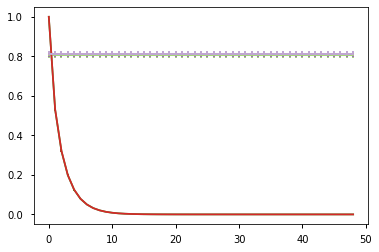

In [8]:
colors = plt.cm.tab20(range(10))
z = 0
fig, ax = plt.subplots()
for k, v in settings.items():
    v = v.data.squeeze()
    x = np.arange(v.shape[-1])
    print(v.shape)
    for vi in range(v.shape[-2]):
        d =  v[z, :, vi]
        ax.errorbar(x, d.mean(0), yerr = 2 * d.std(0), color = colors[vi])
fig.show()

In [ ]:
fig, ax = plt.subplots()

sets = [0,1]
for k, v in aucs.items():
    v = v.squeeze()
    for i in range(v.shape[1]):
        for j in range(v.shape[-1]):
            ax.scatter(*v[sets, i, j], color = colors[j], label = j)
            ax.scatter(*v[sets, :, j].mean(1), color = colors[j], marker = '+', s = 1500)

In [ ]:
tmp = next(iter(loadedData))

ld = loadedData[tmp].squeeze()
mi = ld[0]
s = mi.shape
params = dict(\
             maxfev = int(1e4),\
             bounds = (0, np.inf),\
             )
mi = np.array([np.pad(si, (0, 20), 'linear_ramp', end_values = (0, 0)) for si in mi.reshape(-1, s[-1])])
mi = mi.reshape(*s[:-1], -1)
print(mi.shape, s)
plt.plot(mi[0,0])
coeffs, err = plotz.fit(mi.reshape(-1, mi.shape[-1]), func, params = params)
coeffs = coeffs.reshape(*mi.shape[:-1], -1)


In [ ]:
from matplotlib import style
style.use('seaborn-notebook')
%matplotlib notebook

x = np.linspace(0, 50)
fig, ax = plt.subplots()

test = np.zeros((coeffs.shape[0], 10))

print(coeffs.shape, test.shape)
for i in range(10):
    for j in range(coeffs.shape[0]):
        ax.plot(x, func(x, *coeffs[j, i]), color = colors[i], alpha = .2)
        test[j, i] = scipy.integrate.quad(lambda x: func(x, *coeffs[j, i]), 0, np.inf)[0]
        ax.plot(mi[j, i], color = colors[i], linestyle = 'none', marker = '.',)
h = [plt.Line2D([0], [0], marker = '.', linestyle = 'none',\
                color = colors[i], label = i) for i in range(10)\
    ]
ax.legend(handles = h) 
fig, ax = plt.subplots()
ax.imshow(test)
fig.show()

In [ ]:
fig, ax = plt.subplots()

settingName = next(iter(loadedData))
setting = settings[settingName]
graph = nx.node_link_graph(setting.graph)
import networkx as nx
from Utils.plotting import addGraphPretty
addGraphPretty(ax = ax, graph = graph)
fig.show()

# Notes on the data

Rick mentioned that it could be the case that although the data does not look linear, it is because each graph has some slightly odd behavior in regards of how the entropy decays. Meaning, it could be that across graphs the lines are not necessarily on a line. However, the prediction accuracy should still be high.

Things to check:
    - Check the ordering over time of the curves for different datasets
    - Check the prediction accuracy
    

In [ ]:
from bokeh import plotting as bp
from bokeh.models import ColumnDataSource, CustomJS
import bokeh
bp.output_notebook()


tmp_aucs = [i.squeeze() for i in aucs.values()]
x = []

sets = [0, 2]

for i in tmp_aucs:
    idx = i[sets[1]].argmax()
#     tmp = i[sets].max(-1)
    tmp  = i[sets, idx]
#     print(i.shape)
    x.append(tmp)

tmp_aucs = np.asarray(x)
# print(tmp_aucs.shape, idx.shape); assert 0

tmp_mi   = [loadedData[i].squeeze() for i in aucs.keys()]
tmp_mi   = tmp_mi

viridis = bokeh.palettes.Viridis256
# setup data
buffer          = ColumnDataSource('x', 'y', \
                                   data = dict(x = [], \
                                               y = [], \
                                               color = [])\
                                  )

buffer_causal   = ColumnDataSource('x', 'y', \
                                   data = dict(x = [], \
                                               y = [],\
                                              color = []),\
                                  )

aucs_bokeh = ColumnDataSource('x', 'y', data = dict(x = tmp_aucs[:,0].tolist(), \
                                                    y = tmp_aucs[:, 1].tolist(), \
                                                    ),\
                              )

mi_bokeh    = ColumnDataSource(data = dict(y = [i[0].tolist() for i in tmp_mi]))
causal_bokeh= ColumnDataSource(data = dict(y = [i[sets[-1]].tolist() for i in tmp_mi]))

f1 = bp.figure(tools = 'hover tap lasso_select'.split(), width = 600)
f2 = bp.figure( height = int(f1.plot_height * .5 ))
f3 = bp.figure( height = int(f1.plot_height * .5 ))

for prop, label in zip('yaxis xaxis'.split(), ['Mutual information', 'time']):
    getattr(f2, prop).axis_label = label

for prop, label in zip('yaxis xaxis'.split(), ['Causal impact', 'time']):
    getattr(f3, prop).axis_label = label
f1.scatter('x', 'y', source = aucs_bokeh, size = 10)

# fi1.scatter()
f2.multi_line('x', 'y', source = buffer, color = 'color')
f3.multi_line(xs = 'x', ys = 'y', source = buffer_causal, color = 'color')

with open('dashboard.js', 'r') as f:
    callback = ''.join(i for i in f.readlines())
    
    JS =  CustomJS(\
             args = dict(buffer = buffer, \
                         mi     = mi_bokeh, \
                         buffer_causal = buffer_causal, \
                         causal = causal_bokeh, 
                         colors = bokeh.palettes.Magma256,\
              ),\
             code = callback)
aucs_bokeh.selected.js_on_change('indices', \
                                JS)
bp.show(bokeh.layouts.row(f1, bokeh.layouts.column(f2, f3)))


# AUC for all data

showing the data for not only the driver-node

In [ ]:
# aucs = {}
# for k, v in loadedData.items():
#     v = v.squeeze()
#     s = v.shape
#     v = v.reshape(v.shape[0], -1)
#     mi, ma = v.min(1), v.max(1)
#     print(v.shape)
#     mi = mi[:, None]
#     ma = ma[:, None]
# 
#     v = (v - mi) / (ma - mi)
#     print(v.max(1))
#     v = v.reshape(s)
#     aucs[k] = np.trapz(v, axis = -1)
for k, v in loadedData.items(): print(v.shape)
predictions = np.zeros((len(loadedData), 2))

for idx, (k, v) in enumerate(aucs.items()):
    jdx = v.squeeze().argmax(-1)
    tmp = v.squeeze().argsort(-1)
    jdx = tmp[:, -1]
#     print(np.argsort(v.squeeze(), axis = -1)[:, -3:])
    tmp = jdx[0] == jdx[1:]
#     print(jdx, v.shape)
    predictions[idx] = tmp

fig = bp.figure()
colors = bokeh.palettes.Viridis256

N = len(colors) // len(aucs)
for idx,(k, v) in enumerate(aucs.items()):
    fig.scatter(*v.squeeze()[[0,2]], color = colors[idx * N])
#     print(v.squeeze()[[0,1]])
fig.xaxis.axis_label = 'Informational impact'
fig.yaxis.axis_label = 'Causal impact'
print(predictions.mean(0))
bp.show(fig)

In [ ]:
func = lambda x, a, b, c, d, e, f: a + b * np.exp(- c * x) + d * np.exp(- e * (x - f))
x = np.linspace(0, 20)
def idt(data, func, perc = .5, params = {}):
    """
    Compute idt for data set (node x time)
    """
    from Utils.plotting import fit
    coeffs, error = fit(data, func, params = params)
    idts = np.zeros((data.shape[0]))
    for idx, c in enumerate(coeffs):
        tmp = lambda x : abs(func(x, *c) - data[idx].max() * perc)
        idts[idx] = scipy.optimize.fmin(tmp, np.random.rand(), disp = 0)[0]
    return idts, coeffs
%matplotlib notebook
from matplotlib import style
style.use('seaborn-notebook')
params = dict(\
             maxfev = int(1e4),\
             bounds = (0, np.inf),\
             )
mi = next(iter(loadedData.values())).squeeze()
auc = next(iter(aucs.values())).squeeze()
print(mi.shape)
zdx = 2 
idts, coeffs = idt(mi[zdx], func, .5, params)

fig, ax = plt.subplots()

colors = plt.cm.tab20(range(12))
for idx, vi in enumerate(mi[zdx]):
    ax.plot(vi, color = colors[idx], linestyle = 'none', marker=  '.', markersize = 10,\
           label = setting.rmapping[str(idx)])
    ax.axvline(idts[idx], color = colors[idx], alpha = .7, linestyle = ':', markersize = 1600)
    ax.plot(x, func(x, *coeffs[idx]), color = colors[idx], linestyle = 'dashed')
    
#     if idx == auc[zdx].argmax():
#         ax.add_artist(plt.Circle((20, 1) , color = colors[idx]))
ax.set(\
      xlabel = 'Time',\
      ylabel = 'KL-divergence' if zdx != 0 else 'Mutual information',\
      ) 

ax.legend()
fig.show()

In [ ]:
mu = mi.mean(1)
# var = mi.std(1)

from scipy.stats import sem
var = sem(mi, axis = 1)
print(var)
setting = next(iter(settings.values()))
print(setting.mapping)
print(mu.shape)

theta = 4
times = np.zeros((3), dtype = int)

fig, ax = plt.subplots()
for idx, i in enumerate(mi):
    for jdx, j in enumerate(i.T):
        dd = np.argsort(j)
        second, first = dd[-2:]
        ax.scatter(jdx,  (j[first] - j[second])**2, color = colors[idx])
        if jdx > 0:
            print(idx, j[first], mu[idx, jdx] + theta * var[idx, jdx])
            
            if j[first] > mu[idx, jdx] + theta * var[idx, jdx]:
                times[idx] = jdx
            else:
                break
            
print(times)
print(setting.rmapping)
for idx, i in enumerate(times):
    node = mi[idx, :, i].argmax()
    print(idx, setting.rmapping[str(node)])
print(times)

In [ ]:
# fig, ax = plt.subplots()
# colors = plt.cm.Spectral(np.linspace(0, 1, len(tmp_aucs)))
# [ax.scatter(*i[:2], color = colors[idx]) for idx, i in enumerate(tmp_aucs)]
# fig.show()

idx = []
for k, v in aucs.items():
    # get max
    tmp = np.argsort(v.squeeze(), axis = -1)
    if tmp[0, -1] != tmp[1, -1]:
        idx.append(k)


In [ ]:
tmp = idx[0]
setting = settings[tmp]
print(aucs[tmp].argsort(-1))
print(len(idx))
def idt(data, perc = .5, params = {}):
    """
    Compute idt for data set (node x time)
    """
    from Utils.plotting import fit
    
    func = lambda x, a, b, c, d, e, f: a + b * np.exp(- c * x) + d * np.exp(- e * (x - f))
    coeffs, error = fit(data, func, params = params)
    idts = np.zeros((data.shape[0]))
    for idx, c in enumerate(coeffs):
        tmp = lambda x : abs(func(x, *c) - data[idx].max() * perc)
        idts[idx] = scipy.optimize.fmin(tmp, np.random.rand(), \
                                       disp = 0)[0]
    return idts


print(settings[tmp])
        
import matplotlib.pyplot as plt
d = loadedData[tmp].squeeze()


idts = idt(d[1], params = dict(bounds = (0, np.inf), maxfev = int(1e4)))
idts2= idt(d[0], params = dict(bounds = (0, np.inf), maxfev = int(1e4)))
print(d.shape)


colors = plt.cm.tab20(range(d.shape[1]))
fig, (ax, tax, ttax) = plt.subplots(1, 3)
for node in range(d.shape[1]):
    ax.plot(d[0, node], color = colors[node])
    ax.axvline(idts2[node], color = colors[node])
    tax.plot(d[1, node], color = colors[node], linestyle = 'dashed')
    ttax.plot(d[2, node], color = colors[node])
    tax.axvline(idts[[node]], color = colors[node])
tax.set(ylabel = 'causal')
tax.yaxis.labelpad = 0
ax.set(ylabel = 'informational')

# elements = [plt.Line2D([0], [0], linestyle = i, color = 'k', label = j) for i, j in zip(\
#                    'dashed solid'.split(), 'causal informational'.split())]
# ax.legend(handles = elements)
mainax = fig.add_subplot(111, xticks = [] , yticks = [], frameon = False)
mainax.set_xlabel('time', labelpad = 20)

inax = tax.inset_axes([0.5, 0.5, 0.7, 0.7])
import networkx as nx
graph = nx.node_link_graph(settings[tmp].graph)
from Utils.plotting import addGraphPretty
addGraphPretty(graph, positions = nx.spring_layout, ax = inax, colors = colors)
inax.axis('off')
fig.subplots_adjust(wspace = .4)
print(np.argsort(aucs[tmp], axis = -1).squeeze())
print(settings[tmp])


from Utils import IO

IO.savePickle('../craph_graph3.pickle', nx.node_link_graph(setting.graph))

100%|██████████| 420/420 [00:40<00:00, 22.41it/s]